In [1]:
# %env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
# %env LLM_API_KEY=替换为自己的key

In [2]:
# %%capture --no-stderr
# !pip install -U langchain langchain_community langchain_openai pypdf sentence_transformers chromadb shutil openpyxl

In [3]:
# import langchain, langchain_community, pypdf, sentence_transformers, chromadb, langchain_core

# for module in (langchain, langchain_core, langchain_community, pypdf, sentence_transformers, chromadb):
#     print(f"{module.__name__:<30}{module.__version__}")

In [4]:
import os
import pandas as pd

In [5]:
expr_version = 'retrieval_v3_rag_fusion'

preprocess_output_dir = r""
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

# 读取文档

In [6]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data_test', 'GeoChat.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

d:\Anaconda\envs\gold-yolo\lib\site-packages\pypdf\_crypt_providers\_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


# 文档切分

In [7]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [8]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


# 检索

In [9]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='Generate a representation for this sentence to retrieve related articles：'
    )
    return embeddings

device: cuda


In [10]:
import shutil
from langchain_community.vectorstores import Chroma

model_path = 'BAAI/bge-large-en-v1.5'

persist_directory = os.path.join(expr_dir, 'chroma')
shutil.rmtree(persist_directory, ignore_errors=True)

embeddings = get_embeddings(model_path)
vector_db = Chroma.from_documents(
    splitted_docs,
    embedding=embeddings,
    persist_directory=persist_directory
)

d:\Anaconda\envs\gold-yolo\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [11]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

## 不使用RAG Fusion

In [12]:
def get_emb_retriever(k):
    return vector_db.as_retriever(search_kwargs={'k': k})

In [13]:
from tqdm.auto import tqdm

def get_hit_stat_df(get_retriever_fn, top_k_arr=list(range(1, 9))):
    hit_stat_data = []
    pbar = tqdm(total=len(top_k_arr) * len(test_df))
    for k in top_k_arr:
        pbar.set_description(f'k={k}')
        retriever = get_retriever_fn(k)
        
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            
            chunks = retriever.invoke(question)[:k]
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
            pbar.update(1)
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [14]:
orig_query_hit_stat_df = get_hit_stat_df(get_emb_retriever)
orig_query_hit_stat_df['rag_fusion'] = 'w/o'

k=8: 100%|██████████| 800/800 [00:14<00:00, 53.43it/s]


In [15]:
orig_query_hit_stat_df

,question,top_k,hit,retrieved_chunks,rag_fusion
0,What is proposed to address the limitations me...,1,0,1,w/o
1,What is one of the types of data used in the n...,1,0,1,w/o
2,What kind of data is mentioned as being abunda...,1,0,1,w/o
3,What does GeoChat require to generate visually...,1,0,1,w/o
4,What types of responses can GeoChat generate?,1,0,1,w/o
...,...,...,...,...,...
795,Which journal published the paper 'transformer...,8,1,8,w/o
796,What is the focus of the research described in...,8,0,8,w/o
797,Who are the authors of the work published in T...,8,1,8,w/o
798,On what pages was the paper about land-use cla...,8,1,8,w/o


## 使用RAG Fusion

In [16]:
from langchain_community.chat_models import ChatOllama
from langchain.prompts import PromptTemplate
import re

llm = ChatOllama(base_url='http://localhost:11434', model='qwen2:7b-instruct')

prompt = PromptTemplate(
    input_variables=['question', 'n_sim_queries'],
#     template = """你是一个AI语言模型助手。你的任务是基于给定的原始问题，再生成出来最相似的{n_sim_query}个不同的版本。\
# 你的目标是通过生成用户问题不同视角的版本，帮助用户克服基于距离做相似性查找的局限性。\
# 使用换行符来提供这些不同的问题，使用换行符来切分不同的问题，不要包含数字序号，仅返回结果即可，不要添加任何其他描述性文本。
# 原始问题：{question}
# """
    template = """You are an AI language model assistant. Your task is to generate the most similar {n_sim_queries} different versions based on the given original question.\
    Your goal is to help users overcome the limitations of distance-based similarity search by generating different perspectives of user questions.\
    Use line breaks to provide these different questions, use line breaks to split different questions, do not include numerical serial numbers, only return the results, and do not add any other descriptive text.
    Original question: {question}
"""
)

generate_queries_chain = (
    prompt
    | llm
    # 有时候模型不遵循指令，把前面的序号去掉
    # | (lambda x: re.sub(r'\d+\.\s', '', x.content))
    # 有时候模型不遵循指令，把前面的序号、- 去掉
    | (lambda x: [
        re.sub(r'(^\-\s+)|(^\d+\.\s)', '', item.strip()) 
        for item in x.content.split('\n') if item.strip() != ''
    ])
)

In [31]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results, k=60):
    fused_scores = {}
    for docs in results:
        # 此处有一个隐含的假设：返回的docs是按相似度排好序的
        for rank, doc in enumerate(docs):
            doc_str = dumps(doc)
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # previous_score = fused_scores[doc_str]
            fused_scores[doc_str] += 1 / (rank + k)
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]
    return reranked_results

In [33]:
def get_rag_fusion_chain(top_k, n_sim_queries=3, trunc=False):
    """
    获取RAG Fusion Chain
    :param top_k: 每个相似问检索的片段数量
    :param trunc: 最终排序后的结果是否要截断为top_k
    """
    chain = (
        prompt.partial(n_sim_queries=n_sim_queries)
        | llm
        # 有时候模型不遵循指令，把前面的序号去掉
        # | (lambda x: re.sub(r'\d+\.\s', '', x.content))
        # 有时候模型不遵循指令，把前面的序号、- 去掉
        | (lambda x: [
            re.sub(r'(^\-\s+)|(^\d+\.\s)', '', item.strip()) 
            for item in x.content.split('\n') if item.strip() != ''])
        | (lambda x: [vector_db.similarity_search(q, k=top_k) for q in x])
        | reciprocal_rank_fusion
        | (lambda docs: docs[:top_k] if trunc else docs)
    )
    return chain

首先先生成相似问题，这个跟Multi Query是类似的

In [22]:
generate_queries_chain.invoke({'question': 'What type of model is GeoChat?', 'n_sim_queries': 3})

['What category does GeoChat belong to in terms of models?',
 'Could you clarify the model classification for GeoChat?',
 'Can you describe the model framework behind GeoChat?']

查看一下中间过程，这个步骤，对于每一个产生的相似问题，检索5个片段

In [23]:
retrieved_docs = (
    generate_queries_chain
    | (lambda x: [vector_db.similarity_search(q, k=5) for q in x])
).invoke({'question': 'What type of model is GeoChat?', 'n_sim_queries': 3})

In [27]:
retrieved_docs

[[Document(metadata={'page': 5, 'source': './data_test/GeoChat.pdf', 'uuid': '2d4b64d7-8302-4f94-b5e3-1f321a10c54c'}, page_content='Figure 5. Qualitative results of GeoChat. ( left-right ) Results are shown on grounding, referring object detection, and disaster/damage\ndetection. The user can provide task-specific tokens (e.g., [grounding] ) to shape model responses according to the desired behavior. The\nmodel can generate textual responses ( right ), only visual grounding ( center ) and both text and object groundings interleaved together ( left).'),
  Document(metadata={'page': 0, 'source': './data_test/GeoChat.pdf', 'uuid': '33890465-ae6c-42b4-85cf-b5d2e06849fc'}, page_content='Figure 1. GeoChat can accomplish multiple tasks for remote-\nsensing (RS) image comprehension in a unified framework. Given\nsuitable task tokens and user queries, the model can generate visu-\nally grounded responses (text with corresponding object locations\n- shown on top), visual question answering on im

In [25]:
len(retrieved_docs)

3

In [26]:
len(retrieved_docs[0])

5

In [37]:
len(get_rag_fusion_chain(3).invoke({'question': 'What type of model is GeoChat?'}))

3

In [35]:
get_rag_fusion_chain(3).invoke({'question': 'What type of model is GeoChat?'})

[(Document(metadata={'page': 3, 'source': './data_test/GeoChat.pdf', 'uuid': '94b6816d-3791-43e5-a3e3-6a3068a63c8c'}, page_content="<System Message>A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to thehuman's questions.. Figure 2. An overview of GeoChat - the first grounded large vision-language model for remote sensing. Given an image input together\nwith a user query, a visual backbone is first used to encode patch-level tokens at a higher resolution via interpolating positional encodings."),
  0.04946236559139784),
 (Document(metadata={'page': 0, 'source': './data_test/GeoChat.pdf', 'uuid': '33890465-ae6c-42b4-85cf-b5d2e06849fc'}, page_content='Figure 1. GeoChat can accomplish multiple tasks for remote-\nsensing (RS) image comprehension in a unified framework. Given\nsuitable task tokens and user queries, the model can generate visu-\nally grounded responses (text with corresponding object locations\

如果确认rag_fusion_chain没有问题，可以直接设置trunc为True，确保召回数量符合设定值

In [36]:
get_rag_fusion_chain(2, trunc=True).invoke({'question': 'What type of model is GeoChat?'})

[(Document(metadata={'page': 0, 'source': './data_test/GeoChat.pdf', 'uuid': '33890465-ae6c-42b4-85cf-b5d2e06849fc'}, page_content='Figure 1. GeoChat can accomplish multiple tasks for remote-\nsensing (RS) image comprehension in a unified framework. Given\nsuitable task tokens and user queries, the model can generate visu-\nally grounded responses (text with corresponding object locations\n- shown on top), visual question answering on images and regions\n(top left and bottom right, respectively) as well as scene classifi-\ncation (top right) and normal natural language conversations (bot-'),
  0.04972677595628415),
 (Document(metadata={'page': 3, 'source': './data_test/GeoChat.pdf', 'uuid': '94b6816d-3791-43e5-a3e3-6a3068a63c8c'}, page_content="<System Message>A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to thehuman's questions.. Figure 2. An overview of GeoChat - the first grounded large vision-langu

为了方便调参，我们创建一个新的函数，使用下面这个函数

In [42]:
def retrieve_with_rrf(llm, query, top_k=4, n_sim_query=3, include_original=True, trunc=True):
    """
    使用RRF检索
    :param llm: 用于生成相似问题的LLM
    :param query: 需要检索的问题
    :param top_k: 每个问题检索几个知识片段
    :param n_sim_query: 每个query生成几个相似问题
    :param include_original: 检索知识片段时，是否包含原始问题
    :param trunc: 是否将最终检索结果，截断为top_k
    """
    chain = (
        prompt.partial(n_sim_queries=n_sim_query)
        | llm
        # 有时候模型不遵循指令，把前面的序号、- 去掉
        | (lambda x: [
            re.sub(r'(^\-\s+)|(^\d+\.\s)', '', item.strip()) 
            for item in x.content.split('\n') if item.strip() != ''])
        | (lambda x: [vector_db.similarity_search(q, k=top_k) for q in ([query] if include_original else []) + x[:n_sim_query]])
        | reciprocal_rank_fusion
        | (lambda docs: docs[:top_k] if trunc else docs)
    )
    return chain.invoke(query)

In [43]:
def get_rag_fusion_hit_stat_df(query_gen_llm, top_k_arr=list(range(1, 9))):
    hit_stat_data = []
    pbar = tqdm(total=len(top_k_arr) * len(test_df))
    for k in top_k_arr:
        pbar.set_description(f'k={k}')
        # rag_fusion_chain = get_rag_fusion_chain(k, trunc=True)
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            # chunks = rag_fusion_chain.invoke({'question': question})
            chunks = retrieve_with_rrf(query_gen_llm, question, top_k=k)
            assert len(chunks) <= k
            
            retrieved_uuids = [doc.metadata['uuid'] for doc, score in chunks]

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
            pbar.update(1)
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [64]:
from langchain_openai import ChatOpenAI

qwen2_14b_llm = ChatOpenAI(
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    api_key=" ",
    model='qwen-vl-plus'
)
# qwen2_14b_llm = ChatOpenAI(
#     base_url="http://127.0.0.1:60031/v1",
#     api_key="ollama",
#     model='qwen2:7b-instruct'
# )
# 我的openai api_key：sk-hZwl8KRwzfYLbJIM9GNkIhiVJiCrPqqJKhWP-7YriRT3BlbkFJRdSNsKbTB0QyhU1ZcBUyc0kMSirZ7Y7pn6EFP67ioA

rag_fusion_hit_stat_dfs = []
for llm_name, llm_model in zip(['ollama-qwen2-7b-instruct', 'qwen2-57b-a14b-instruct'], [llm, qwen2_14b_llm]):
    rag_fusion_hit_stat_df = get_rag_fusion_hit_stat_df(llm_model)
    rag_fusion_hit_stat_df['rag_fusion'] = f'w/ {llm_name}'
    rag_fusion_hit_stat_dfs.append(rag_fusion_hit_stat_df)

OperationalError: cannot start a transaction within a transaction

In [57]:
qwen2_14b_llm.invoke("你是谁？")

APIConnectionError: Connection error.

In [27]:
hit_stat_df = pd.concat([orig_query_hit_stat_df] + rag_fusion_hit_stat_dfs)

In [28]:
hit_stat_df.groupby(['rag_fusion', 'top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,rag_fusion,top_k,hit_rate
0,w/ ollama-qwen2-7b-instruct,1,0.451613
1,w/ ollama-qwen2-7b-instruct,2,0.591398
2,w/ ollama-qwen2-7b-instruct,3,0.666667
3,w/ ollama-qwen2-7b-instruct,4,0.741935
4,w/ ollama-qwen2-7b-instruct,5,0.806452
5,w/ ollama-qwen2-7b-instruct,6,0.784946
6,w/ ollama-qwen2-7b-instruct,7,0.817204
7,w/ ollama-qwen2-7b-instruct,8,0.838710
8,w/ qwen2-57b-a14b-instruct,1,0.462366
9,w/ qwen2-57b-a14b-instruct,2,0.580645


<Axes: xlabel='top_k', ylabel='hit'>

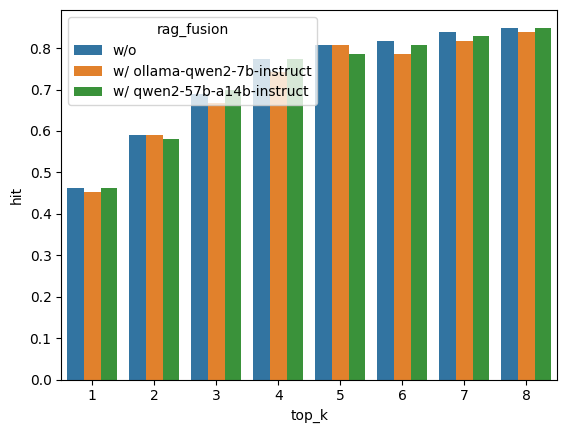

In [29]:
import seaborn as sns

sns.barplot(x='top_k', y='hit', hue='rag_fusion', data=hit_stat_df, errorbar=None)

# 预测

In [30]:
from langchain.llms import Ollama

ollama_llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434'
)

In [31]:
# ollama_llm.invoke('你是谁')

'我是阿里云开发的一款超大规模语言模型，我叫通义千问。作为一个AI助手，我的目标是帮助用户获得准确、有用的信息，解决他们的问题和困惑。我会不断学习和进步，努力提供更好的服务。如果您有任何问题或需要帮助，请随时告诉我，我会尽力提供支持。'

In [32]:
def rag(query_gen_llm, question, n_chunks=3):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{question}}
请回答：
""".strip()

    # rag_fusion_chain = get_rag_fusion_chain(n_chunks, trunc=True)
    # chunks = rag_fusion_chain.invoke({'question': question})
    
    chunks = retrieve_with_rrf(query_gen_llm, question, top_k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([pair[0].page_content for pair in chunks])).replace('{{question}}', question)

    return ollama_llm(prompt), chunks

In [34]:
print(rag(llm, '2023年10月美国ISM制造业PMI指数较上月有何变化？')[0])

/opt/anaconda3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


2023年10月，美国ISM制造业PMI指数较上个月大幅下降了2.3个百分点。


In [35]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(query_gen_llm, prediction_df, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(query_gen_llm, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }
    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [36]:
n_chunks = 3

pred_df_dict = {}
for llm_name, llm_model in zip(['ollama-qwen2-7b-instruct', 'qwen2-57b-a14b-instruct'], [llm, qwen2_14b_llm]):
    pred_df_dict[llm_name] = predict(llm_model, prediction_df, n_chunks=n_chunks)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# 评估

In [37]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        result = judge_llm.invoke(prompt).content
        results.append(result)

        time.sleep(1)
    return results

In [39]:
for model_name, pred_df in pred_df_dict.items():
    pred_df['raw_score'] = evaluate(pred_df)
    print(f"{model_name}: {pred_df['raw_score'].unique()}")
    pred_df.loc[:, 'score'] = pred_df['raw_score'].replace({'是': 1, '否': 0})

  0%|          | 0/100 [00:00<?, ?it/s]

ollama-qwen2-7b-instruct: ['是' '否']


/tmp/ipykernel_2336286/2492278847.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pred_df.loc[:, 'score'] = pred_df['raw_score'].replace({'是': 1, '否': 0})


  0%|          | 0/100 [00:00<?, ?it/s]

qwen2-57b-a14b-instruct: ['是' '否']


/tmp/ipykernel_2336286/2492278847.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pred_df.loc[:, 'score'] = pred_df['raw_score'].replace({'是': 1, '否': 0})


In [40]:
pred_df_dict['ollama-qwen2-7b-instruct']['score'].mean()

0.69

In [41]:
pred_df_dict['qwen2-57b-a14b-instruct']['score'].mean()

0.69

In [ ]:
for model_name, pred_df in pred_df_dict.items():
    pred_df.to_excel(os.path.join(expr_dir, f'prediction_{model_name}.xlsx'), index=False)